The 2-dimensional linear wave equation in co-energy formulation
===============================================================

The objective of this example is to show how sub-domains may be used, and how substitutions reduce the computational burden: it assumes that [this 2D wave example](https://g-haine.github.io/scrimp/examples/wave.html) has already been studied.

Substitutions
-------------

The damped wave equation as a port-Hamiltonian system writes
$$
    \begin{pmatrix} \partial_t \alpha_q \\ \partial_t \alpha_p \\ f_r \end{pmatrix}
    =
    \begin{bmatrix} 0 & {\rm grad} & 0 \\ {\rm div} & 0 & -I \\ 0 & I^\top & 0 \end{bmatrix}
    \begin{pmatrix} e_q \\ e_p \\ e_r \end{pmatrix},
$$
where $\alpha_q$ denotes the strain, $\alpha_p$ is the linear momentum, $e_q$ is the stress, $e_p$ is the velocity and $(f_r,e_r)$ is the dissipative port.

This system must be close with **constitutive relations**, which are
$$
    e_q = T \cdot \alpha_q, \qquad e_p = \frac{\alpha_p}{\rho}, \qquad e_r = \nu f_r,
$$
where $T$ is the Young's modulus, $\rho$ the mass density and $\nu$ the viscosity. Inverting these relations and substituting the results in the port-Hamiltonian system leads to the **co-energy formulation** (or more generally **co-state formulation**)
$$
    \begin{pmatrix} T^{-1} \cdot \partial_t e_q \\ \rho \partial_t e_p \\ \nu^{-1} e_r \end{pmatrix}
    =
    \begin{bmatrix} 0 & {\rm grad} & 0 \\ {\rm div} & 0 & -I \\ 0 & I^\top & 0 \end{bmatrix}
    \begin{pmatrix} e_q \\ e_p \\ e_r \end{pmatrix}.
$$

At the discrete level, this allows to reduce the number of degrees of freedom by two.

**Remark:** In the example, $\nu$ only acts on a sub-domain, *i.e.* it is theoretically null on the complementary, and thus could not be invert! To be able to invert it, it is then mandatory to restrict the dissipative port to the sub-domain where $\nu>0$.

Simulation
----------

Let us start quickly until the definition of the dissipative port.

In [1]:
# Import scrimp
import scrimp as S

# Init the distributed port-Hamiltonian system
wave = S.DPHS("real")

# Set the domain (using the built-in geometry `Concentric`)
# Labels: Disk = 1, Annulus = 2, Interface = 10, Boundary = 20
omega = S.Domain("Concentric", {"R": 1.0, "r": 0.6, "h": 0.1})

# And add it to the dphs
wave.set_domain(omega)

## Define the variables
states = [
    S.State("q", "Stress", "vector-field"),
    S.State("p", "Velocity", "scalar-field"),
]
# Use of the `substituted=True` keyword to get the co-energy formulation
costates = [
    S.CoState("e_q", "Stress", states[0], substituted=True),
    S.CoState("e_p", "Velocity", states[1], substituted=True),
]

# Add them to the dphs
for state in states:
    wave.add_state(state)
for costate in costates:
    wave.add_costate(costate)

A model with real unknowns has been initialized
A disk of radius 0.6 surrounded by an annulus of radii 0.6 and 1.0 has been meshed
Domain has been set
Domain is set and contains 1 mesh(es):
=== on mesh 0 of dim 2
* Subdomains are: {'Omega_Disk': 1, 'Omega_Annulus': 2}
* Boundaries are: {'Interface': 10, 'Gamma': 20}
domain: Concentric has been set
state: q has been added
state: p has been added
port: q has been added 
costate: e_q has been added to state: q
state: q has new costate: e_q
port: p has been added 
costate: e_p has been added to state: p
state: p has new costate: e_p


message from gf_mesh_get follow:
gfMesh object in dimension 2 with 451 points and 835 elements



In order to restrict the dissipative port to the internal disk, we use the `region` keyword.

In [2]:
# Define the dissipative port, only on the subdomain labelled 1 = the internal disk
ports = [
    S.Port("Damping", "e_r", "e_r", "scalar-field", substituted=True, region=1),
]

# Add it to the dphs
for port in ports:
    wave.add_port(port)

port: Damping has been added on region 1


The control port is only at the external boundary, labelled by 20 in **SCRIMP**.

In [3]:
# Define the control port
control_ports = [
    S.Control_Port(
        "Boundary control",
        "U",
        "Normal force",
        "Y",
        "Velocity trace",
        "scalar-field",
        region=20,
    ),
]

# Add it to the dphs
for ctrl_port in control_ports:
    wave.add_control_port(ctrl_port)

port: Boundary control has been added on region 20


The sequel is as for the already seen examples.

In [4]:
# Define the Finite Elements Method of each port
FEMs = [
    # name of the variable: (is the same of states, ports and controls ports), order, FEM
    S.FEM(states[0].get_name(), 1, "DG"),
    S.FEM(states[1].get_name(), 2, "CG"),
    S.FEM(ports[0].get_name(), 1, "DG"),
    S.FEM(control_ports[0].get_name(), 1, "DG"),
]

# Add them to the dphs
for FEM in FEMs:
    wave.add_FEM(FEM)

# Define physical parameters: care must be taken, 
# in the co-energy formulation, some parameters are
# inverted in comparison to the classical formulation
parameters = [
    S.Parameter(
        "Tinv",
        "Young's modulus inverse",
        "tensor-field",
        "[[5+x,x*y],[x*y,2+y]]",
        "q",
    ),
    S.Parameter("rho", "Mass density", "scalar-field", "3-x", "p"),
    S.Parameter(
        "nu",
        "Viscosity",
        "scalar-field",
        "10*(0.36-(x*x+y*y))",
        ports[0].get_name(),
    ),
]

# Add them to the dphs
for parameter in parameters:
    wave.add_parameter(parameter)

FEM_PK_DISCONTINUOUS(2,1) has been set for port q
FEM_PK(2,2) has been set for port p
FEM_PK_DISCONTINUOUS(2,1) has been set for port Damping
FEM_PK_DISCONTINUOUS(2,1) has been set for port Boundary control
Tinv has been added to port: q
Tinv has been set to [[5+x,x*y],[x*y,2+y]] in port: q
Tinv has been initialized with the FEM of port: q
rho has been added to port: p
rho has been set to 3-x in port: p
rho has been initialized with the FEM of port: p
nu has been added to port: Damping
nu has been set to 10*(0.36-(x*x+y*y)) in port: Damping
nu has been initialized with the FEM of port: Damping


message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 451 points, 835 elements and 5010 degrees of freedom

message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 451 points, 835 elements and 1734 degrees of freedom

message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 451 points, 835 elements and 2505 degrees of freedom

message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 451 points, 835 elements and 2505 degrees of freedom



Regarding the `Brick` objects, there is a major difference with the previous examples: here, we need to list **all** the sub-domain labels for the wave equation, hence the `[1,2]`. On the other hand, the dissipation only occurs on the internal disk, labelled 1, and thus the block matrices corresponding to the identity operators which implement the dissipation **must be restrict to** `[1]`.

In [5]:
# Define the pHs via `Brick` == non-zero block matrices == variational terms
# Since we use co-energy formulation, constitutive relations are already taken into
# account in the mass matrices M_q and M_p
bricks = [
    ## Define the Dirac structure
    # Define the mass matrices from the left-hand side: the `flow` part of the Dirac structure
    S.Brick("M_q", "q.Tinv.Test_q", [1, 2], dt=True, position="flow"),
    S.Brick("M_p", "p*rho*Test_p", [1, 2], dt=True, position="flow"),
    S.Brick("M_r", "e_r/nu*Test_e_r", [1], position="flow"),
    S.Brick("M_Y", "Y*Test_Y", [20], position="flow"),
    # Define the matrices from the right-hand side: the `effort` part of the Dirac structure
    S.Brick("D", "Grad(p).Test_q", [1, 2], position="effort"),
    S.Brick("-D^T", "-q.Grad(Test_p)", [1, 2], position="effort"),
    S.Brick("I_r", "e_r*Test_p", [1], position="effort"),
    S.Brick("B", "U*Test_p", [20], position="effort"),
    S.Brick("-I_r^T", "-p*Test_e_r", [1], position="effort"),
    S.Brick("-B^T", "-p*Test_Y", [20], position="effort"),
    ## Define the constitutive relations
    # Already taken into account in the Dirac Structure!
]

# Add all these `Bricks` to the dphs
for brick in bricks:
    wave.add_brick(brick)

Linear form  'q.Tinv.Test_q' has been added as: flow relation on region: 1 of mesh: 0
Linear form  'q.Tinv.Test_q' has been added as: flow relation on region: 2 of mesh: 0
Linear form  'p*rho*Test_p' has been added as: flow relation on region: 1 of mesh: 0
Linear form  'p*rho*Test_p' has been added as: flow relation on region: 2 of mesh: 0
Linear form  'e_r/nu*Test_e_r' has been added as: flow relation on region: 1 of mesh: 0
Linear form  'Y*Test_Y' has been added as: flow relation on region: 20 of mesh: 0
Linear form  'Grad(p).Test_q' has been added as: effort relation on region: 1 of mesh: 0
Linear form  'Grad(p).Test_q' has been added as: effort relation on region: 2 of mesh: 0
Linear form  '-q.Grad(Test_p)' has been added as: effort relation on region: 1 of mesh: 0
Linear form  '-q.Grad(Test_p)' has been added as: effort relation on region: 2 of mesh: 0
Linear form  'e_r*Test_p' has been added as: effort relation on region: 1 of mesh: 0
Linear form  'U*Test_p' has been added as: ef

The remaining part of the code have already been explain in previous examples.

Linear form  '-U*Test_U' has been added as: constitutive relation on region: 20 of mesh: 0
Source form  '0.5*Y' has been added as: source relation on region: 20 of mesh: 0
Control port: Boundary control has been set to: U = 0.5*Y on region: 20 of mesh: 0
q has been set
q has been initialized with: [0., 0.]
p has been set
p has been initialized with: 2.72**(-20*((x-0.5)*(x-0.5)+(y-0.5)*(y-0.5)))
Simulation is starting on 1 processor(s) (total number of dofs: 7905)
Starting linear mass matrix assembly...
Linear mass matrix assembly done in 0.09778s
Starting linear stiffness matrix assembly...
Linear stiffness matrix assembly done in 0.1133s
Perform initialisation using 1 step(s) of a pseudo scheme, with timestep 0.0001, for initial value consistency
Initialisation done in 0.0726s


i=       0 t=       0 * (0s)   dt=    0.01        
i=       1 t=    0.01 * (0s)   dt=    0.01        
i=       2 t=    0.02 * (0s)   dt=    0.01        
i=       3 t=    0.03 * (0s)   dt=    0.01        
i=       4 t=    0.04 * (0s)   dt=    0.01        
i=       5 t=    0.05 * (0s)   dt=    0.01        
i=       6 t=    0.06 * (0s)   dt=    0.01        
i=       7 t=    0.07 * (0s)   dt=    0.01        
i=       8 t=    0.08 * (0s)   dt=    0.01        
i=       9 t=    0.09 * (0s)   dt=    0.01        
i=      10 t=     0.1 * (0s)   dt=    0.01        
i=      11 t=    0.11 * (0s)   dt=    0.01        
i=      12 t=    0.12 * (0s)   dt=    0.01        
i=      13 t=    0.13 * (0s)   dt=    0.01        
i=      14 t=    0.14 * (0s)   dt=    0.01        
i=      15 t=    0.15 * (0s)   dt=    0.01        
i=      16 t=    0.16 * (0s)   dt=    0.01        
i=      17 t=    0.17 * (0s)   dt=    0.01        
i=      18 t=    0.18 * (0s)   dt=    0.01        
i=      19 t=    0.19 * (0s)   

Elapsed time: 8.598s
Steps: 200 (0 rejected, 0 Nonlinear solver failures)
Nonlinear iterations: 200, Linear iterations: 200
Start computing the Hamiltonian
Hamiltonian has been computed in 0.5465061943978071 s
Start computing the powers (substituted ports are not automated)
Power cannot be computed for dynamic or substituted port q
Power cannot be computed for dynamic or substituted port p
Power cannot be computed for dynamic or substituted port Damping
Start computing the power flowing through Boundary control
Power in Boundary control has been computed in 0.026261473074555397 s
Powers have been computed in 0.028242284432053566 s


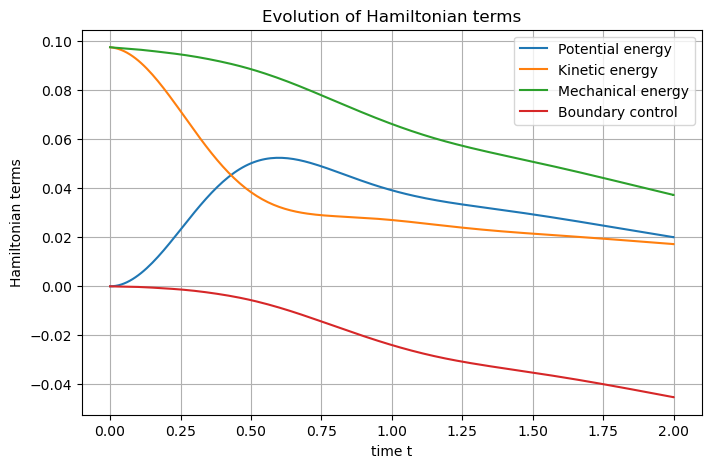

In [6]:
## Initialize the problem
# The controls expression
expressions = ["0.5*Y"]

# Add each expression to its control_port
for control_port, expression in zip(control_ports, expressions):
    # Set the control functions (automatic construction of bricks such that -M_u u + f(t) = 0)
    wave.set_control(control_port.get_name(), expression)

# Set the initial data
wave.set_initial_value("q", "[0., 0.]")
wave.set_initial_value("p", "2.72**(-20*((x-0.5)*(x-0.5)+(y-0.5)*(y-0.5)))")

## Solve in time
# Define the time scheme ("cn" is Crank-Nicolson)
wave.set_time_scheme(ts_type="cn",
                     t_f=2.0, 
                     dt_save=0.01,
                     )

# Solve
wave.solve()

## Post-processing
## Set Hamiltonian's name
wave.hamiltonian.set_name("Mechanical energy")
# Define each Hamiltonian Term
terms = [
    S.Term("Potential energy", "0.5*q.Tinv.q", [1, 2]),
    S.Term("Kinetic energy", "0.5*p*p*rho", [1, 2]),
]
# Add them to the Hamiltonian
for term in terms:
    wave.hamiltonian.add_term(term)

# Plot the Hamiltonian and save the output
wave.plot_Hamiltonian(save_figure=True)